In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-scientist-linkedin-job-postings/postings.csv


### Model 1 for generating job summary by OpenAI


In [3]:
df = pd.read_csv('/kaggle/input/data-scientist-linkedin-job-postings/postings.csv')
df

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Remote,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Onsite,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Onsite,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Remote,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Hybrid,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."
...,...,...,...,...,...,...,...,...,...,...,...
4337,Data Science & Analytics Consultant,ADLIB Recruitment | B Corp™,"Bristol, England, United Kingdom",https://uk.linkedin.com/jobs/view/data-science...,2023-12-20,Newport,United Kingdom,Mid senior,Onsite,"Grow your career at a successful, Bristol base...","Data analytics, Data science, SQL, Python, Tab..."
4338,Senior Data Scientist,Harnham,"Bristol, England, United Kingdom",https://uk.linkedin.com/jobs/view/senior-data-...,2023-12-20,Newport,United Kingdom,Mid senior,Onsite,To Apply for this Job Click Here\nSENIOR DATA ...,"Data Science, Machine Learning, Python, R, Sta..."
4339,Associate/Principal Mechanical Engineer - Data...,Hydrock,"Bristol, England, United Kingdom",https://uk.linkedin.com/jobs/view/associate-pr...,2023-12-20,Newport,United Kingdom,Mid senior,Onsite,Job Advert\nWe have a fantastic opportunity fo...,"Mechanical Engineering, Data Centre Design, Pr..."
4340,Senior Data Scientist,Robert Half,"Bristol, England, United Kingdom",https://uk.linkedin.com/jobs/view/senior-data-...,2023-12-20,Newport,United Kingdom,Mid senior,Hybrid,Robert Half partners exclusively with Envelop ...,"Python, SQL, Tableau, Power BI, GCP, AWS, Azur..."


In [ ]:
df.job_summary.tolist()

In [4]:
import pandas as pd
import re
from bs4 import BeautifulSoup

# Define a cleaning function
def clean_job_description(text):
    # Check for NaN values and handle them
    if isinstance(text, float):  # Handles NaN values
        return ""
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply cleaning to the 'job_summary' column
df['cleaned_job_summary'] = df['job_summary'].apply(clean_job_description)

# Preview the cleaned dataset
print(df[['job_summary', 'cleaned_job_summary']].head())


/tmp/ipykernel_2501/536215640.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


                                         job_summary  \
0  Why Choose Jefferson Health Plans?\nWe are an ...   
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   

                                 cleaned_job_summary  
0  why choose jefferson health plans\nwe are an a...  
1  job responsibilities\ndeployment  inscope conf...  
2  success factor knowledge\nschedule  monday thr...  
3  company description\nnbc sports next is where ...  
4  national grid renewables is a leading north am...  


In [5]:
pip install langchain

Note: you may need to restart the kernel to use updated packages.


In [6]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Assuming the cleaning has been applied to the 'cleaned_job_summary' column
# Remove invalid or empty entries after cleaning
cleaned_documents = df['cleaned_job_summary'].dropna().tolist()
cleaned_documents = [doc for doc in cleaned_documents if isinstance(doc, str) and doc.strip()]

# Convert cleaned strings to Document objects
doc_objects = [Document(page_content=doc) for doc in cleaned_documents]

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

# Split the documents into smaller chunks
chunks = text_splitter.split_documents(doc_objects)

# Display results
for idx, chunk in enumerate(chunks[:5]):  # Preview the first 5 chunks
    print(f"Chunk {idx + 1}: {chunk.page_content}")


Chunk 1: why choose jefferson health plans
we are an awardwinning notforprofit health maintenance organization we are committed to creating a community where everyone belongs acknowledges and celebrates diversity and has opportunities to grow to their fullest potential
while this job currently provides a flexible remote option due to inoffice meetings training as required or other business needs our employees are to be residents of pa or the nearby states of de or nj
Chunk 2: perks of jhp and why you will love it here
competitive compensation packages including 401k savings plan with company match and profit sharing
flextime and workathome options
benefits  wellness program including generous time off
impact on the communities we service
we are seeking a talented and enthusiastic technical data analyst to join our team
Chunk 3: the data operations team primary function is to provide access to various clinical and financial data to management to support the business decision process dat

In [ ]:
pip install chromadb

In [ ]:
pip install -U langchain-community

In [ ]:
pip install sentence-transformers

In [7]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

# Load a free embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create a Chroma vector store
vector_store = Chroma.from_documents(chunks, embedding=embedding_model, persist_directory="chroma_db")


/tmp/ipykernel_2501/205515783.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})  # Retrieve top 3 relevant chunks

In [9]:
from transformers import pipeline

# Load a summarization pipeline using a free model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
def summarize_job_description(query):
    # Retrieve relevant chunks based on the query
    retrieved_docs = retriever.get_relevant_documents(query)
    
    # Concatenate the retrieved chunks into a single text
    context = " ".join([doc.page_content for doc in retrieved_docs])

    # Generate the summary
    summary = summarizer(context, max_length=150, min_length=50, do_sample=False)
    return summary[0]["summary_text"]

# Example usage
query = "Summarize the key skills, experience level, and job title for this role."
summary = summarize_job_description(query)
print(summary)

In [ ]:
summaries = []
for job in cleaned_documents:
    summary = summarizer(job, max_length=150, min_length=50, do_sample=False)
    summaries.append(summary[0]["summary_text"])

# Add the summaries back to the dataset
df1 = []
df1 = df.dropna('cleaned_job_summary')
df1["summaries"] = summaries
df1["summaries"]

In [ ]:
pip install openai pandas


In [10]:
import os
import openai

# Set OpenAI API key
os.environ["OPENAI_API_KEY"] = "SET YOUR OWN OPENAI KEY"
openai.api_key = os.getenv("OPENAI_API_KEY")


In [11]:
def summarize_text_openai(text, max_tokens=150):
    try:
        response = openai.Completion.create(
            engine="text-davinci-003",  # Use a GPT model (e.g., "gpt-4" or "text-davinci-003")
            prompt=f"You are a helpful assistant. The following data are the job description in the LinkedIn. Summarize the following job description with fluent sentences with the company name, job title, how many years of experience, skills needed.",
            max_tokens=max_tokens,
            temperature=0.7,  # Adjust creativity level
            top_p=1,
            n=1,
            stop=None
        )
        return response.choices[0].text.strip()
    except Exception as e:
        return f"Error: {str(e)}"


In [ ]:
pip install openai==0.28


In [12]:
import pandas as pd



# Clean and fill NaN job summaries
df["job_summary"] = df["job_summary"].fillna("No description available.")

# Apply the summarization function to the job_summary column
df["summaries"] = df["job_summary"].apply(lambda x: summarize_text_openai(x, max_tokens=150))

# Preview results
print(df[["job_summary", "summaries"]].head())


                                         job_summary  \
0  Why Choose Jefferson Health Plans?\nWe are an ...   
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   

                                           summaries  
0  Error: The model `text-davinci-003` has been d...  
1  Error: The model `text-davinci-003` has been d...  
2  Error: The model `text-davinci-003` has been d...  
3  Error: The model `text-davinci-003` has been d...  
4  Error: The model `text-davinci-003` has been d...  


In [15]:
import openai

# Using gpt-3.5-turbo or gpt-4
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",  # Or use "gpt-4" for higher-quality results
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "The following data are the job description in the LinkedIn. Summarize the following job description with fluent sentences with the company name, job title, how many years of experience, skills needed."}    ],
    max_tokens=100,
    temperature=0.7
)

# Extract the result
print(response["choices"][0]["message"]["content"])


Company Name: XYZ Corporation
Job Title: Senior Marketing Manager
Experience: 5+ years
Skills Needed: The ideal candidate should have a minimum of 5 years of experience in marketing, with a proven track record of developing and executing successful marketing strategies. Strong analytical skills, excellent communication abilities, and proficiency in digital marketing tools are essential. The candidate should also possess leadership qualities, be detail-oriented, and have a creative mindset to drive innovative marketing campaigns.


In [19]:
import openai
import pandas as pd
from tqdm import tqdm

# Load your dataset
df = pd.read_csv('/kaggle/input/data-scientist-linkedin-job-postings/postings.csv')

# Clean the job_summary column (if not already cleaned)
df['job_summary'] = df['job_summary'].fillna('')  # Replace NaN with empty strings

# Set your OpenAI API key
openai.api_key = "SET YOUR OWN OPENAI KEY"

# Function to summarize job descriptions
def summarize_job(job_description):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",  # You can use "gpt-4" for better quality
            messages=[
                {"role": "system", "content": "The following data are the job description in the LinkedIn. Summarize the following job description with fluent sentences with the company name, job title, how many years of experience, skills needed."},
                {"role": "user", "content": f"Summarize this job description: {job_description}"}
            ],
            max_tokens=100,
            temperature=0.7
        )
        return response["choices"][0]["message"]["content"]
    except Exception as e:
        print(f"Error summarizing job description: {e}")
        return None
from tqdm import tqdm

# Apply the summarization function to only the first 200 rows
tqdm.pandas()  # Progress bar for long operations
df.loc[:199, 'job_summary_summary'] = df.loc[:199, 'job_summary'].progress_apply(summarize_job)

# Save the DataFrame with the summaries
df.to_csv("summarized_job_descriptions.csv", index=False)

# Preview the resulting DataFrame
print(df[['job_summary', 'job_summary_summary']].head(10))  # Display the first 10 rows


100%|██████████| 200/200 [05:00<00:00,  1.50s/it]


                                         job_summary  \
0  Why Choose Jefferson Health Plans?\nWe are an ...   
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   
5  VCS\nis looking for\nBusiness Data Analyst\nfo...   
6  Contract to hire opportunity.\nClient requirem...   
7  Description\nThe pay range is: $96,283.00 - $1...   
8  We're utilizing modern technology to fresh con...   
9  Description: The pay range is $92,000.00 - $16...   

                                 job_summary_summary  
0  Company: Jefferson Health Plans\n\nJob Title: ...  
1  Company Name: Not specified\nJob Title: IT Inf...  
2  Company: Not Specified\nJob Title: Data Manage...  
3  Company: NBC Sports Next\nJob Title: Data Engi...  
4  Company: National Grid Renewables\n\nJob Title...  
5  Vish Consulting Services (VCS) is seeking a Bu... 

In [24]:
df.job_summary_summary[0:200]

0      Company: Jefferson Health Plans\n\nJob Title: ...
1      Company Name: Not specified\nJob Title: IT Inf...
2      Company: Not Specified\nJob Title: Data Manage...
3      Company: NBC Sports Next\nJob Title: Data Engi...
4      Company: National Grid Renewables\n\nJob Title...
                             ...                        
195    Company: Grammarly\nJob Title: Data Engineer\n...
196    Company: Northrop Grumman\nJob Title: Principa...
197    Company: Leading financial services corporatio...
198    The job is for a DataStage Developer position ...
199    Company: Raas Infotek Corporation  \nJob Title...
Name: job_summary_summary, Length: 200, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the original and summarized text
tfidf_matrix = vectorizer.fit_transform(df["job_summary"].fillna("") + df["summaries"])

# Calculate cosine similarity between original and summarized text
cosine_scores = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Diagonal elements represent the self-similarity (original vs. summary)
relevancy_scores = [cosine_scores[i, i] for i in range(len(df))]

# Add relevancy scores to the dataset
df["relevancy_score"] = relevancy_scores

# Preview dataset with relevancy scores
print(df[["job_summary", "summaries", "relevancy_score"]].head())

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for original and summarized text
original_embeddings = model.encode(df.loc[:199, 'job_summary'].fillna(''))
summary_embeddings = model.encode(df.loc[:199, 'job_summary_summary'].fillna(''))

# Calculate cosine similarity for each row
cosine_similarities = [
    cosine_similarity(
        original_embeddings[i].reshape(1, -1),
        summary_embeddings[i].reshape(1, -1)
    )[0][0]
    for i in range(len(original_embeddings))
]

# Add relevancy score to the DataFrame
df.loc[:199, 'relevancy_score'] = cosine_similarities

# Check results
print(df[['job_summary', 'job_summary_summary', 'relevancy_score']].head(10))


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

                                         job_summary  \
0  Why Choose Jefferson Health Plans?\nWe are an ...   
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   
5  VCS\nis looking for\nBusiness Data Analyst\nfo...   
6  Contract to hire opportunity.\nClient requirem...   
7  Description\nThe pay range is: $96,283.00 - $1...   
8  We're utilizing modern technology to fresh con...   
9  Description: The pay range is $92,000.00 - $16...   

                                 job_summary_summary  relevancy_score  
0  Company: Jefferson Health Plans\n\nJob Title: ...         0.702362  
1  Company Name: Not specified\nJob Title: IT Inf...         0.505946  
2  Company: Not Specified\nJob Title: Data Manage...         0.739400  
3  Company: NBC Sports Next\nJob Title: Data Engi...         0.343409  
4  Company: National Gr

In [27]:
df.relevancy_score.mean()

0.64468596175313

In [31]:
pip install Rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [32]:
from rouge import Rouge
import pandas as pd

# Initialize the ROUGE scorer
rouge = Rouge()

# Function to calculate ROUGE score
def calculate_rouge(row):
    if pd.isna(row['job_summary']) or pd.isna(row['job_summary_summary']):
        return 0  # Return 0 if any text is missing
    scores = rouge.get_scores(row['job_summary_summary'], row['job_summary'])
    # Use ROUGE-1 F1 score as relevancy score (you can also use recall or precision)
    return scores[0]['rouge-1']['f']

# Apply ROUGE score calculation to the first 200 rows
df.loc[:199, 'rouge_score'] = df.loc[:199].apply(calculate_rouge, axis=1)

# Check the results
print(df[['job_summary', 'job_summary_summary', 'relevancy_score','rouge_score']].head(10))


                                         job_summary  \
0  Why Choose Jefferson Health Plans?\nWe are an ...   
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   
5  VCS\nis looking for\nBusiness Data Analyst\nfo...   
6  Contract to hire opportunity.\nClient requirem...   
7  Description\nThe pay range is: $96,283.00 - $1...   
8  We're utilizing modern technology to fresh con...   
9  Description: The pay range is $92,000.00 - $16...   

                                 job_summary_summary  relevancy_score  \
0  Company: Jefferson Health Plans\n\nJob Title: ...         0.702362   
1  Company Name: Not specified\nJob Title: IT Inf...         0.505946   
2  Company: Not Specified\nJob Title: Data Manage...         0.739400   
3  Company: NBC Sports Next\nJob Title: Data Engi...         0.343409   
4  Company: Nation

In [34]:
df['rouge_score'].mean()

0.23328048113713729

In [38]:
df

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills,job_summary_summary,relevancy_score,rouge_score
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Remote,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log...",Company: Jefferson Health Plans\n\nJob Title: ...,0.702362,0.242424
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Onsite,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz...",Company Name: Not specified\nJob Title: IT Inf...,0.505946,0.138728
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Onsite,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C...",Company: Not Specified\nJob Title: Data Manage...,0.739400,0.338235
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Remote,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL...",Company: NBC Sports Next\nJob Title: Data Engi...,0.343409,0.163355
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Hybrid,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene...",Company: National Grid Renewables\n\nJob Title...,0.710166,0.317690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4337,Data Science & Analytics Consultant,ADLIB Recruitment | B Corp™,"Bristol, England, United Kingdom",https://uk.linkedin.com/jobs/view/data-science...,2023-12-20,Newport,United Kingdom,Mid senior,Onsite,"Grow your career at a successful, Bristol base...","Data analytics, Data science, SQL, Python, Tab...",NaN,NaN,NaN
4338,Senior Data Scientist,Harnham,"Bristol, England, United Kingdom",https://uk.linkedin.com/jobs/view/senior-data-...,2023-12-20,Newport,United Kingdom,Mid senior,Onsite,To Apply for this Job Click Here\nSENIOR DATA ...,"Data Science, Machine Learning, Python, R, Sta...",NaN,NaN,NaN
4339,Associate/Principal Mechanical Engineer - Data...,Hydrock,"Bristol, England, United Kingdom",https://uk.linkedin.com/jobs/view/associate-pr...,2023-12-20,Newport,United Kingdom,Mid senior,Onsite,Job Advert\nWe have a fantastic opportunity fo...,"Mechanical Engineering, Data Centre Design, Pr...",NaN,NaN,NaN
4340,Senior Data Scientist,Robert Half,"Bristol, England, United Kingdom",https://uk.linkedin.com/jobs/view/senior-data-...,2023-12-20,Newport,United Kingdom,Mid senior,Hybrid,Robert Half partners exclusively with Envelop ...,"Python, SQL, Tableau, Power BI, GCP, AWS, Azur...",NaN,NaN,NaN


In [39]:
df.to_csv("summarized_job_descriptions_1.csv", index=False)

In [37]:
job_1 = "We are CARIAD, an automotive software development team with the Volkswagen Group. Our mission is to make the automotive experience safer, more sustainable, more comfortable, more digital, and more fun. To achieve that we are building the leading tech stack for the automotive industry and creating a unified software platform for over 10 million new vehicles per year. We’re looking for talented, digital minds like you to help us create code that moves the world. Together with you, we’ll build outstanding digital experiences and products for all Volkswagen Group brands that will transform mobility. Join us as we shape the future of the car and everyone around it."
test1 = summarize_job(job_1)
print(test1)

Company: CARIAD, automotive software development team within the Volkswagen Group.

Job Title: Digital Software Engineer.

Experience: Not specified in the job description.

Skills needed: The ideal candidate should possess talent and digital skills to create innovative code for the automotive industry. They should have a strong background in software development and be passionate about creating outstanding digital experiences and products. Additionally, the candidate should have the ability to work collaboratively in a team to shape the future of mobility.


In [ ]:
import pandas as pd
df1 = pd.read_csv("summarized_job_descriptions_1.csv")
df1

In [2]:
pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=2d4d10b716dca46f9b55b6485dec03746b616f7e1933db04f7635149f56c96d8
  Stored in directory: /Users/yixie/Library/Caches/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [5]:
from rouge_score import rouge_scorer
import pandas as pd

# Load your DataFrame (replace with your actual data if it's already loaded)
df = pd.read_csv("/Users/yixie/Downloads/job_posting_withscore.csv")

# Define a function to compute ROUGE scores
def compute_rouge(reference, candidate):
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Calculate scores
    scores = scorer.score(reference, candidate)
    
    # Extract and return the metrics
    return {
        "rouge1": scores["rouge1"].fmeasure,
        "rouge2": scores["rouge2"].fmeasure,
        "rougeL": scores["rougeL"].fmeasure
    }

# Apply the function to calculate ROUGE scores for each row
# Assuming 'job_summary' is the reference and 'job_summary_summary' is the generated text
df['rouge_scores'] = df.apply(
    lambda row: compute_rouge(row['job_summary'], row['job_summary_summary']),
    axis=1
)

# Split the scores into separate columns for better readability
df['rouge1'] = df['rouge_scores'].apply(lambda x: x['rouge1'])
df['rouge2'] = df['rouge_scores'].apply(lambda x: x['rouge2'])
df['rougeL'] = df['rouge_scores'].apply(lambda x: x['rougeL'])

# Save the DataFrame with ROUGE scores
df.to_csv("summarized_job_descriptions_with_rouge.csv", index=False)

# Preview the resulting DataFrame
print(df[['job_summary', 'job_summary_summary', 'rouge1', 'rouge2', 'rougeL']].head(10))



                                         job_summary  \
0  Why Choose Jefferson Health Plans?\nWe are an ...   
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   
5  VCS\nis looking for\nBusiness Data Analyst\nfo...   
6  Contract to hire opportunity.\nClient requirem...   
7  Description\nThe pay range is: $96,283.00 - $1...   
8  We're utilizing modern technology to fresh con...   
9  Description: The pay range is $92,000.00 - $16...   

                                 job_summary_summary    rouge1    rouge2  \
0  Company: Jefferson Health Plans\n\nJob Title: ...  0.222222  0.192366   
1  Company Name: Not specified\nJob Title: IT Inf...  0.248000  0.096386   
2  Company: Not Specified\nJob Title: Data Manage...  0.534759  0.345946   
3  Company: NBC Sports Next\nJob Title: Data Engi...  0.160622  0.116883   
4  

In [6]:
df.rouge1.mean()

0.24451879027821588

In [7]:
df.rouge2.mean()

0.16040370244996116

In [9]:
df.rougeL.mean()

0.19109079661598444

In [15]:
def calculate_rouge_scores(reference, candidate):
    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    
    # Calculate scores
    scores = scorer.score(reference, candidate)
    
    # Return ROUGE-1 and ROUGE-L F1-scores
    return {
        "rouge1_f1": scores["rouge1"].fmeasure,  # ROUGE-1 F1-score
        "rougeL_f1": scores["rougeL"].fmeasure  # ROUGE-L F1-score
    }


In [16]:
# Apply the ROUGE scoring function to the dataset
df['rouge_scores'] = df.apply(
    lambda row: calculate_rouge_scores(row['job_summary'], row['job_summary_summary']),
    axis=1
)

# Extract ROUGE-1 and ROUGE-L F1-scores into separate columns
df['rouge1_f1'] = df['rouge_scores'].apply(lambda x: x['rouge1_f1'])
df['rougeL_f1'] = df['rouge_scores'].apply(lambda x: x['rougeL_f1'])


In [17]:
# Calculate mean ROUGE scores
rouge1_mean = df['rouge1_f1'].mean()
rougeLsum_mean = df['rougeL_f1'].mean()

# Print the mean scores
print(f"ROUGE-1 Mean F1: {rouge1_mean}")
print(f"ROUGE-Lsum Mean F1: {rougeLsum_mean}")


ROUGE-1 Mean F1: 0.24451879027821588
ROUGE-Lsum Mean F1: 0.19109079661598444


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


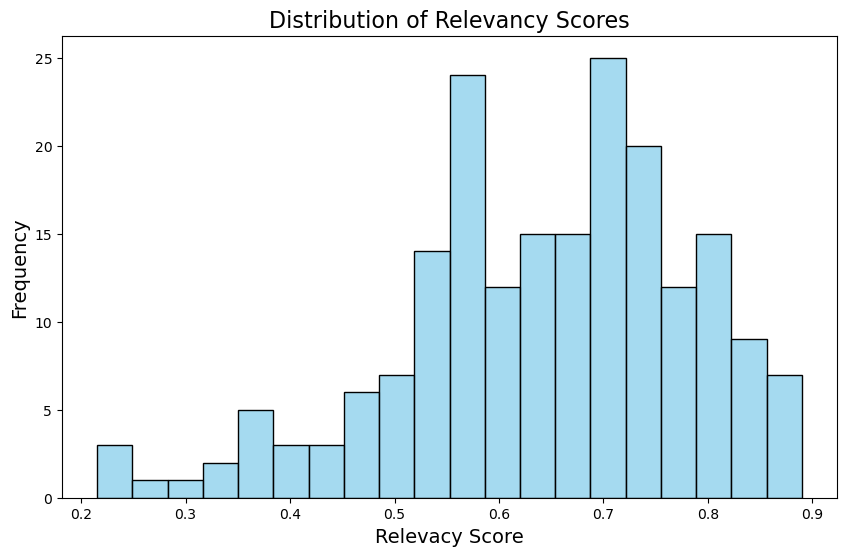

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the distribution of 'rouge1_f1' column using a barplot
plt.figure(figsize=(10, 6))
sns.histplot(df['relevancy_score'], bins=20, kde=False, color='skyblue')  # Set bins for more granularity

# Add labels and title
plt.title("Distribution of Relevancy Scores", fontsize=16)
plt.xlabel("Relevacy Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show the plot
plt.show()
